In [48]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import contextlib
import pandas as pd
import numpy as np
import statsmodels.api as sm
# import mne
import warnings
import tensorflow.compat.v2 as tfcompat
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp
from sympy import primerange
from scipy.stats import zscore
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras import losses, metrics, initializers
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from pandas.plotting import register_matplotlib_converters
from sklearn.preprocessing import StandardScaler
from IPython.display import Image

with contextlib.suppress(ValueError):
	tf.compat.v2.enable_v2_behavior()
if tf.test.gpu_device_name() != '/device:GPU:0':
	print('WARNING: GPU device not found.')
else:
	print(f'SUCCESS: Found GPU: {tf.test.gpu_device_name()}')

register_matplotlib_converters()
sns.reset_defaults()
sns.set_style('whitegrid')
sns.set_context('talk')
sns.set_context(context='talk', font_scale=0.7)
tfcompat.enable_v2_behavior()
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter("ignore")
# mne.set_log_level('WARNING')
warnings.simplefilter("ignore")
is_tf_eager = f'tf is executing eagerly? {tf.executing_eagerly()}'
print(tf.__version__)


2.10.0


In [24]:
tfd = tfp.distributions
tfb = tfp.bijectors
tfl = tfp.layers
tfo = tfp.optimizer
DTYPE = tf.float64

tf.random.set_seed(1)
np.random.seed(1)

In [25]:
def prepare_df(df1, df2):
	""" Returns the X and y into one continuous dataframe """
	out = pd.concat([df1, df2])
	out.reset_index(inplace=True, drop=True)
	return out


def microvolt_output(*df):
	"""
	Normal brainwaves output 10 - 30 microvolts(uV) before passing through a Fast Fourier Transform (FFT)
	Returns the summary stats of all leads in the df in uV after passing through a FFT.
	The important differences here are the distances between the 75th percentile and the max values.
	This distance is ~ 40 standard deviations from the mean in the baseline and ~ 23 in the seizure.
	"""
	out = list(enumerate(df))  # out[0][1] is the first dataframe object.
	out0, out1 = out[0][1].describe().T, out[1][1].describe().T
	test0_means, test1_means = out0.mean(), out1.mean()
	dfout = pd.concat([test0_means, test1_means], axis=1).T
	dfout.rename(index={0: 'baseline', 1: 'seizure'}, inplace=True)
	return dfout.T


def df_prep(df):
	""" Returns a dataframe for the raw data stored in the csv """
	df1 = pd.read_csv(df)
	df1.drop('Unnamed: 0', inplace=True, axis=1)
	if len(df1) <= 10240:
		df1.reset_index(inplace=True, drop=True)
		return df1
	p1 = df1.iloc[662272:, :]
	p1.reset_index(inplace=True, drop=True)
	return (p1 - p1.mean()) / p1.std()


def where_uV_gt_oh_point_1(dfX, dfy):
	"""
	Returns a reduced dataframe of the originals but only uV above 0.1
	There are no values below this threshold that are related to the seizure.
	This fact derived from the huge distance between the 75th percentile and the max value in the final row before the seizure begins.
	This is seen later in this notebook.
	"""
	dfX2 = dfX.copy()
	dfX2['means'] = dfX2.mean(axis=1)  # I need higher avg values to pull number so mean
	start = dfX2[dfX2.means > .1].index[0]
	df_X = dfX2.iloc[start:]
	df_X.drop('means', axis=1, inplace=True)
	df_X.reset_index(inplace=True, drop=True)

	dfy_ = dfy.iloc[:len(df_X), :]
	return df_X, dfy_

In [26]:
# csv files
p1_baseline_file = '/Users/jshensley/Desktop/capstone_seizure/seizure_jups/p1_baseline.csv'
p1_seizure_file = '/Users/jshensley/Desktop/capstone_seizure/seizure_jups/p1_seizure.csv'
p18_baseline_file = '/Users/jshensley/Desktop/capstone_seizure/seizure_jups/p18_baseline.csv'
p18_seizure_file = '/Users/jshensley/Desktop/capstone_seizure/seizure_jups/p18_seizure.csv'
vns_baseline_file = '/Users/jshensley/Desktop/capstone_seizure/seizure_jups/vns_baseline.csv'
vnsp_seizure_file = '/Users/jshensley/Desktop/capstone_seizure/seizure_jups/vns_seizure.csv'

# Data prep

Note:

"Base" (as in p1Base)  denotes the recordings before the seizure and it's short for 'patient one's baseline' EEG readings, even though the 'base' set contains the sudden spike in uV before the seizure; therefore, 'Base' is the 'baseline' for the majority of the data set.

"Seize" (as in p1Seizure) denotes the recorded seizure

In [27]:
#########################################################################
# Patient One: from here on out denoted by some variation of 'p1'
# X-train
p1Base_X = df_prep(p1_baseline_file)
p1_Xtensor = tf.Variable(p1Base_X,dtype=DTYPE,name='p1_X')

# y_train
p1Seize_y = df_prep(p1_seizure_file)
p1_ytensor = tf.Variable(p1Seize_y,dtype=DTYPE,name='p1_y')

#########################################################################
# Patient One but 18 months later: from here on out denoted by some variation of 'p18'
# X-train
p18Base_X = df_prep(p18_baseline_file)
p18_Xtensor = tf.Variable(p18Base_X,dtype=DTYPE,name='p18_x').numpy()

# y_train
p18Seize_y = df_prep(p18_seizure_file)
p18_ytensor = tf.Variable(p18Seize_y,dtype=DTYPE,name='p18_y').numpy()

#########################################################################
# Patient with a VNS: from here on out denoted by some variation of 'vns'
# X-train
vnsBase_X = df_prep(vns_baseline_file)
vns_Xtensor = tf.Variable(vnsBase_X,dtype=DTYPE,name='vns_X').numpy()

# y_train
vnspSeize_y = df_prep(vnsp_seizure_file)
vns_ytensor = tf.Variable(vnspSeize_y,dtype=DTYPE,name='vns_y').numpy()

#########################################################################
# p1's continuous data
p1_ = prepare_df(p1Base_X,p1Seize_y)
p1_tensor = tf.Variable(p1_,dtype=DTYPE,name="p1")

# p18's continuous data
p18_ = prepare_df(p18Base_X,p18Seize_y)
p18_tensor = tf.Variable(p18_,dtype=DTYPE,name="p18")

# vns's continuous data
vns_ = prepare_df(vnsBase_X,vnspSeize_y)
vns_tensor = tf.Variable(vns_,dtype=DTYPE,name="vns")

It's important to see the seizure at 10240.
Note how the uV's increase until the seizure's sudden drop.
The energy then  jumps back up.

In [28]:
p1_.iloc[10236:10250]

,FP1-F7,F7-T7,T7-P7,P7-O1,FP1-F3,F3-C3,C3-P3,P3-O1,FP2-F4,F4-C4,...,F8-T8,T8-P8-0,P8-O2,FZ-CZ,CZ-PZ,P7-T7,T7-FT9,FT9-FT10,FT10-T8,T8-P8-1
10236,31.629114,31.579793,29.479894,30.680710,33.510780,31.466153,30.692076,30.485880,33.939171,32.337422,...,32.261218,29.428901,30.206534,31.506593,31.958259,29.479894,32.015315,31.179577,31.440357,29.428901
10237,33.708997,33.243740,30.444402,32.016235,36.751413,33.460409,32.397207,31.909040,37.774925,34.898700,...,33.990468,30.677907,31.046495,33.719314,34.148272,30.444402,33.288373,32.889154,33.008066,30.677907
10238,34.843117,34.151906,30.768939,32.676646,39.038424,34.758680,33.302897,32.622349,40.607076,36.749754,...,34.838476,31.168884,30.867716,35.300480,35.557325,30.768939,33.600139,33.855265,34.108825,31.168884
10239,35.425091,34.491160,30.692781,32.991932,40.473440,35.438399,33.964128,33.199653,42.413717,37.865077,...,35.833894,31.098121,31.750150,36.236319,36.485697,30.692781,34.848866,34.504325,34.627743,31.098121
10240,-0.559274,-0.553105,-0.568051,-0.540807,-0.564997,-0.537198,-0.534766,-0.582277,-0.570141,-0.523867,...,-0.599739,-0.541665,-0.491817,-0.517145,-0.519439,-0.568051,-0.557682,-0.509721,-0.629072,-0.541665
10241,22.706046,22.153794,23.834506,22.805812,24.098736,23.708124,22.906869,22.447269,29.141551,22.312318,...,22.764561,26.212566,21.909738,23.044202,22.988102,23.834506,23.105726,23.512456,26.388301,26.212566
10242,19.825963,21.361974,23.018960,22.080666,20.661425,22.868135,22.297515,21.666525,20.954133,21.461971,...,19.471939,22.010125,21.361547,22.621468,22.472324,23.018960,21.570666,22.770198,20.923296,22.010125
10243,17.334067,20.445016,21.933233,21.310456,17.637132,21.826972,21.524288,20.883771,14.255200,20.472858,...,17.989636,19.372481,20.903107,21.958972,21.702200,21.933233,20.408536,21.795707,18.688279,19.372481
10244,16.459263,19.537962,20.751027,20.250707,16.651512,20.815971,20.542393,19.875212,12.532384,19.626378,...,15.758545,17.413116,20.184998,21.067147,20.673743,20.751027,19.354113,20.727319,14.932665,17.413116
10245,17.238271,18.710014,19.568394,19.215535,17.658062,19.893522,19.393759,18.803833,15.736248,18.956105,...,15.918168,17.612605,19.252005,19.978394,19.428973,19.568394,18.491534,19.593933,15.534702,17.612605


The following code is used to establish parameters needed for future probability distributions.
The float values represent electric potention in micovolts: $\mu$V.

Note the distance between the 75th percentile and the max value for p1.
The other 2 datasets are the same.

In [29]:
p1microvolts = microvolt_output(p1Base_X, p1Seize_y)
p18microvolts = microvolt_output(p18Base_X, p18Seize_y)
vnsmicrovolts = microvolt_output(vnsBase_X, vnspSeize_y)
print(f"Patient one's 75th percentile uV value and the max uV value:\n\n {p1microvolts.loc['75%':'max']}")

Patient one's 75th percentile uV value and the max uV value:

       baseline    seizure
75%  -0.026755   0.145870
max  34.840133  23.732237


# Traditional Linear Regression
This will be a best fit of a 23-D hyperplane using sklearn.linear_model.Ridge because there is support for multiple variables. This is of course impossible to plot.

In [30]:
from sklearn.linear_model import Ridge

# Probabilistic hyperparameter selection
I will sample a random alpha hyperparameters from an exponential distribution.
This distribution was chosen because alpha will be small and the probability of alpha being large drops exponentially as the x-axis increases.

Alpha's distribution samples is strictly based on the patient's baseline data mean.
Note that I'm only choosing rows less than 8000.

Reviewing patient one's microvoltage 75th percentile df above, one notes that number is infinitesimal compared to the max values seen in the moments leading up to the seizure.

The microvoltage begins to increase during the aura phase in the 9000s and I don't want any of that influencing the mean. Ill take 10 samples for iteration and model selection

In [31]:
# Draw 10 random samples and store it in an array.
alpha_sample = abs(
		tfd.Exponential(rate=1 / p1Base_X.iloc[:8000,:].mean().mean())
		.sample(10)) \
	.numpy()

# To store the accuracy results.
ridge_accuracy_ = {
		'p18 prediction': [],
		'vns prediction': []
}

for _ in alpha_sample:
	ridge = Ridge(alpha=_).fit(p1Base_X,p1Seize_y)

	# Predict patient one 18 months later.
	prediction_on_p18 = ridge.predict(p18Base_X)
	prediction_on_vns = ridge.predict(vnspSeize_y)

	# This is a huge array of predictions.
	# I will take the absolute value of the differences between the actual and predicted, then df it and choose predictions with a difference less than 0.2, and store that result in a list.

	# patient one 18 months later
	diff_ridge_p18 = pd.DataFrame(abs(p18Base_X.to_numpy() - prediction_on_p18))
	ridge_accuracy_p18 = diff_ridge_p18[diff_ridge_p18 < 0.2].notnull().sum(axis=1).sum() / diff_ridge_p18.size

	# vns patient
	diff_ridge_vns = pd.DataFrame(abs(vnspSeize_y.to_numpy() - prediction_on_vns))
	ridge_accuracy_vns = diff_ridge_vns[diff_ridge_vns < 0.2].notnull().sum(axis=1).sum() / diff_ridge_vns.size

	# append ot accuracy
	ridge_accuracy_['p18 prediction'].append(ridge_accuracy_p18)
	ridge_accuracy_['vns prediction'].append(ridge_accuracy_vns)

	# clear dataframes for next loop.
	diff_ridge_p18.drop(diff_ridge_p18.index,inplace=True)
	diff_ridge_vns.drop(diff_ridge_vns.index,inplace=True)

# ~67% is about as good as it's getting.

How accurate were the predictions

In [32]:
print(f"p18: {min(ridge_accuracy_['p18 prediction'])}\nvns: {min(ridge_accuracy_['vns prediction'])}")

p18: 0.6734120244565217
vns: 0.20629670516304346


67% accuracy with the same patient and a dismal 20% with the patient with the vns.

# Clustering with KMeans
Let's see if KMeans can give a baseline cluster and a seizure cluster.

I originally wanted spectral clustering, but the time to converge was stretching into hours and since I'm presenting clustering only for Springbaord purposes (this isn't the correct model for this dataset and nor was linear regression for that matter), I'm keeping things simple.

Let's remember what the two most important summary stats say.

In [33]:
p1_rememeber_the_sumz = pd.concat([p1Base_X.describe().T, p1Seize_y.describe().T], axis=0)
p1_rememeber_the_sumz[['75%', 'max']].mean()

75%     0.059558
max    29.286185
dtype: float64

The distance between the 75th percentile and the max values is huge.
Remember the the data is normalized.
The moments leading up to the seizure have the highest readings in $\mu$V.
The seizure occurs at row index 10240 in all three sets.
Remember as you watch the voltage climb in each row until the seizure that the 75th percentile is 0.05 and the mean is 0.
The electric output is huge compared the the baseline.
My intuition says pretty much anything over 1 is strange and certainly climbing into the 10s is serious.
I would certainly constitute these moments leading up to the seizure an aura.
Furthermore, the values stay high during the seizure.
The onset of the seizure at 10240 is almost like a surge protector failing in its job.

In [34]:
p1_.iloc[10200:10245,:]

,FP1-F7,F7-T7,T7-P7,P7-O1,FP1-F3,F3-C3,C3-P3,P3-O1,FP2-F4,F4-C4,...,F8-T8,T8-P8-0,P8-O2,FZ-CZ,CZ-PZ,P7-T7,T7-FT9,FT9-FT10,FT10-T8,T8-P8-1
10200,1.795170,1.577832,3.618966,3.147948,2.943443,1.843275,3.143669,3.460062,5.125190,2.898204,...,3.524141,3.304338,5.220632,3.039183,3.790190,3.618966,2.904142,2.070500,2.643772,3.304338
10201,1.406141,1.640902,3.856711,3.366803,2.324070,1.902301,3.325362,3.756328,4.522098,3.040222,...,3.107633,3.540421,5.118496,3.213196,4.025672,3.856711,2.292261,1.954890,2.642898,3.540421
10202,1.097124,1.672395,4.038334,3.585109,1.578629,1.867433,3.548790,4.070087,3.651809,2.978763,...,3.166017,3.666136,5.500772,3.191210,4.159132,4.038334,2.494037,1.891624,2.740492,3.666136
10203,0.771215,1.642023,4.150033,3.761691,0.701494,1.750862,3.627621,4.227221,2.554391,2.725901,...,3.215583,3.719558,5.817580,2.986588,4.085501,4.150033,2.884037,1.789771,2.819870,3.719558
10204,0.383961,1.570741,4.224459,3.842979,-0.095535,1.604771,3.418923,4.098271,1.341415,2.361800,...,2.689919,3.751002,5.451888,2.654150,3.738043,4.224459,2.314035,1.587160,2.601591,3.751002
10205,0.190550,1.605756,4.260887,3.932994,0.723588,1.456972,3.327739,4.085091,0.210767,1.949416,...,2.709289,3.782527,5.697599,2.244209,3.387193,4.260887,2.371327,1.566605,2.588650,3.782527
10206,0.253093,1.701239,4.267305,4.000259,1.307418,1.352364,3.348295,4.127649,0.410232,1.519987,...,3.107293,3.824960,6.372809,1.804099,3.059112,4.267305,3.028602,1.688325,2.747742,3.824960
10207,0.402718,1.725346,4.317436,4.022685,1.724606,1.356907,3.113135,3.890929,1.244236,1.132860,...,2.508746,3.870794,5.722935,1.410183,2.558948,4.317436,1.905650,1.643635,2.497036,3.870794
10208,0.748078,1.778066,4.407382,4.056261,1.852245,1.471404,2.902587,3.658394,1.765598,0.860489,...,2.001171,3.937499,4.945765,1.118847,2.088433,4.407382,0.653519,1.636896,2.276848,3.937499
10209,1.441334,2.020991,4.484676,4.147141,1.558783,1.647162,3.048383,3.747701,1.829859,0.746734,...,2.853986,4.088092,5.904739,0.961578,1.931851,4.484676,1.744529,1.911912,2.570106,4.088092


So the intuition is that a KMeans  would show a cluster with a small value and another with a large value.

Since clustering may prefer sparse matrices, I will convert all negative values to 0.
This may make it more efficient since negative values mean nothing during a seizure.

In [35]:
from sklearn.cluster import KMeans

# extract the numeric data from each patient's data set and turn negative numbers into zeros.
p1valz = p1_._get_numeric_data()
p1valz[p1valz < 0] = 0

p18valz = p18_._get_numeric_data()
p18valz[p18valz < 0] = 0

vnspvalz = vns_._get_numeric_data()
vnspvalz[vnspvalz < 0] = 0


Since clustering's strength is unstructured data, I will shuffle the datasets.

In [36]:
p1_shuffled = tf.random.shuffle(tf.convert_to_tensor(p1valz), seed=271828, name='shuffled_p1Base')
p18_shuffled = tf.random.shuffle(tf.convert_to_tensor(p18valz), seed=271828, name='shuffled_p18Base')
vnspvalz_shuffled = tf.random.shuffle(vnspvalz, seed=271828, name='shuffled_vnspval')

In [37]:
# Establish a container for each patient's data

gammaccuracy_ = {
		'p1 prediction': {
				'cluster nodes': None,
				'inertia': None,
		},
		'p18 prediction': {
				'cluster nodes': None,
				'inertia': None,
		},
		'vns prediction': {
				'cluster nodes': None,
				'inertia': None
		}
}

In [38]:
# Execute. In test runs, all three fit's converged absolutely  with at most 6 iterations
spectral_model = KMeans(n_clusters=2,n_init=10,max_iter=6,verbose=0)

shuffled_p1 = spectral_model.fit(p1_shuffled)
gammaccuracy_['p1 prediction']['cluster nodes'] = tf.convert_to_tensor(shuffled_p1.cluster_centers_,dtype=DTYPE,
																	   name='p1 cluster_centers')
gammaccuracy_['p1 prediction']['inertia'] = tf.cast(shuffled_p1.inertia_, dtype=DTYPE, name='p1 inertia')

shuffled_p18 = spectral_model.fit(p18_shuffled)
gammaccuracy_['p18 prediction']['cluster nodes'] = tf.convert_to_tensor(shuffled_p18.cluster_centers_,dtype=DTYPE,
																		name='p18 cluster_centers')
gammaccuracy_['p18 prediction']['inertia'] = tf.cast(shuffled_p18.inertia_, dtype=DTYPE, name='p18 inertia')

shuffled_vnsp = spectral_model.fit(vnspvalz_shuffled)
gammaccuracy_['vns prediction']['cluster nodes'] = tf.convert_to_tensor(shuffled_vnsp.cluster_centers_,dtype=DTYPE,
																		name='vnsp cluster_centers')
gammaccuracy_['vns prediction']['inertia'] = tf.cast(shuffled_vnsp.inertia_, dtype=DTYPE, name='vnsp inertia')


Let's take a look see

In [39]:
gammaccuracy_['p1 prediction']

{'cluster nodes': <tf.Tensor: shape=(2, 23), dtype=float64, numpy=
 array([[ 0.105171  ,  0.09754321,  0.10117548,  0.09966077,  0.10019813,
          0.0945925 ,  0.09814813,  0.1061114 ,  0.10626945,  0.0951008 ,
          0.09823887,  0.0975365 ,  0.10785819,  0.11243289,  0.10241717,
          0.10067071,  0.09268807,  0.09469097,  0.10117548,  0.10739061,
          0.09507911,  0.11440712,  0.10241717],
        [17.01688611, 17.50280531, 17.64292932, 17.35883693, 16.77072935,
         17.50359566, 17.46948614, 17.37383317, 16.04921171, 17.00116752,
         17.29941786, 18.03805809, 17.16132653, 17.10385391, 17.44868955,
         17.96710026, 17.41897285, 17.47330641, 17.64292932, 17.59907467,
         17.65440713, 17.5056363 , 17.44868955]])>,
 'inertia': <tf.Tensor: shape=(), dtype=float64, numpy=127018.3046875>}

Promising.

Once cluster is clearly near 0 and the other is much higher, just like the describe method suggested.
As the father and husband to a severe epileptics, this would suggest to me that a seizure had occured in the EEG reading, else all readings would be near 0.

I'll take the mean of each cluster and make it more reader friendly.

In [40]:
print(f"Patient 1\n"
	  f"Centroid 1: {tf.reduce_mean(gammaccuracy_['p1 prediction']['cluster nodes'][0])} mV\n"
	  f"Centroid 2: {tf.reduce_mean(gammaccuracy_['p1 prediction']['cluster nodes'][1])} mV\n\n"
	  f"Patient one 18 months later\n"
	  f"Centroid 1: {tf.reduce_mean(gammaccuracy_['p18 prediction']['cluster nodes'][0])} mV\n"
	  f"Centroid 2: {tf.reduce_mean(gammaccuracy_['p18 prediction']['cluster nodes'][1])} mV\n\n"
	  f"Patient 18\n"
	  f"Centroid 1: {tf.reduce_mean(gammaccuracy_['vns prediction']['cluster nodes'][0])} mV\n"
	  f"Centroid 2: {tf.reduce_mean(gammaccuracy_['vns prediction']['cluster nodes'][1])} mV")

Patient 1
Centroid 1: 0.10134668392412163 mV
Centroid 2: 17.367432331926604 mV

Patient one 18 months later
Centroid 1: 0.10280081187817895 mV
Centroid 2: 19.036510327825678 mV

Patient 18
Centroid 1: 0.11491301122255833 mV
Centroid 2: 26.235263404230007 mV


What's interesting about this is that clustering is really about sheding light on unstructured data.

It seems that, given some raw EEG data and running KMeans on it, a doctor could conclude quickly that something highly abnormal had occurred, and that something could very well increase the probability that it was a seizure.

Currently, EEG data alone is not sufficient to conclude a diagnosis of Epilepsy, and while the goal in this notebook is to find a way to predict seizures, clustering seemed to provide a much simpler way to see abnormal brain wave activity than reading a complicated EEG, but that is an amatuer's opinion.

# ARMA Time Series

In [41]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg

def arma(df):
	df['means'] = df.mean(axis=1)
	df = df.iloc[:10242]
	return df, df.to_numpy()

p1_copy = p1_.copy()
p18_copy = p18_.copy()
vns_copy = vns_.copy()
p1_arma, p1_arma_numpy = arma(p1_copy)
p18_arma, p18_arma_numpy = arma(p18_copy)
vns_arma, vns_arma_numpy = arma(vns_copy)

check_it = np.array(p1_.index)

stationary_or_not = adfuller(p1_arma['means'], maxlag=None, regression='c', autolag='AIC', store=False, regresults=False)
stationary_or_not

(2.4933247555295557,
 0.9990476663980448,
 35,
 10206,
 {'1%': -3.430990892169447,
  '5%': -2.8618232368448373,
  '10%': -2.566920761829341},
 1533.821489887312)

# Explanations for the above list
The below information is included only if you haven't memorized the adfuller method from statsmodels.
I pulled from the following link and substituted my numbers.
https://stackoverflow.com/questions/47349422/how-to-interpret-adfuller-test-results

First data point: ~2.5.: Critical value of the data in your case

Second data point: 0.99...: Probability that null hypothesis will not be rejected(p-value)

Third data point: 35: Number of lags used in regression to determine t-statistic.

Forth data point: 10206: Number of observations used in the analysis.

Fifth data point: {'1%': -3.43..., '5%': -2.86, '10%': -2.566...}: T values corresponding to adfuller test.

The important number here is the 2nd data point. A p-value of 1 is about the worst case scenario ad Ill need to stationarize the data.

In [47]:
p1_log = np.sqrt(abs(p1_arma['means']))
df_diff = p1_log.diff().dropna()
p1_arma['means'] = p1_log

stationary_or_not2 = adfuller(df_diff, maxlag=None, regression='c', autolag='AIC', store=False, regresults=False)
stationary_or_not2

(-22.797703530015124,
 0.0,
 38,
 10202,
 {'1%': -3.430991143513707,
  '5%': -2.861823347912308,
  '10%': -2.5669208209506147},
 -27758.29806834794)

1.710286411422933e-29 is 0 and therefore the data is stationary.

Let's check the autocorrelation of the data.

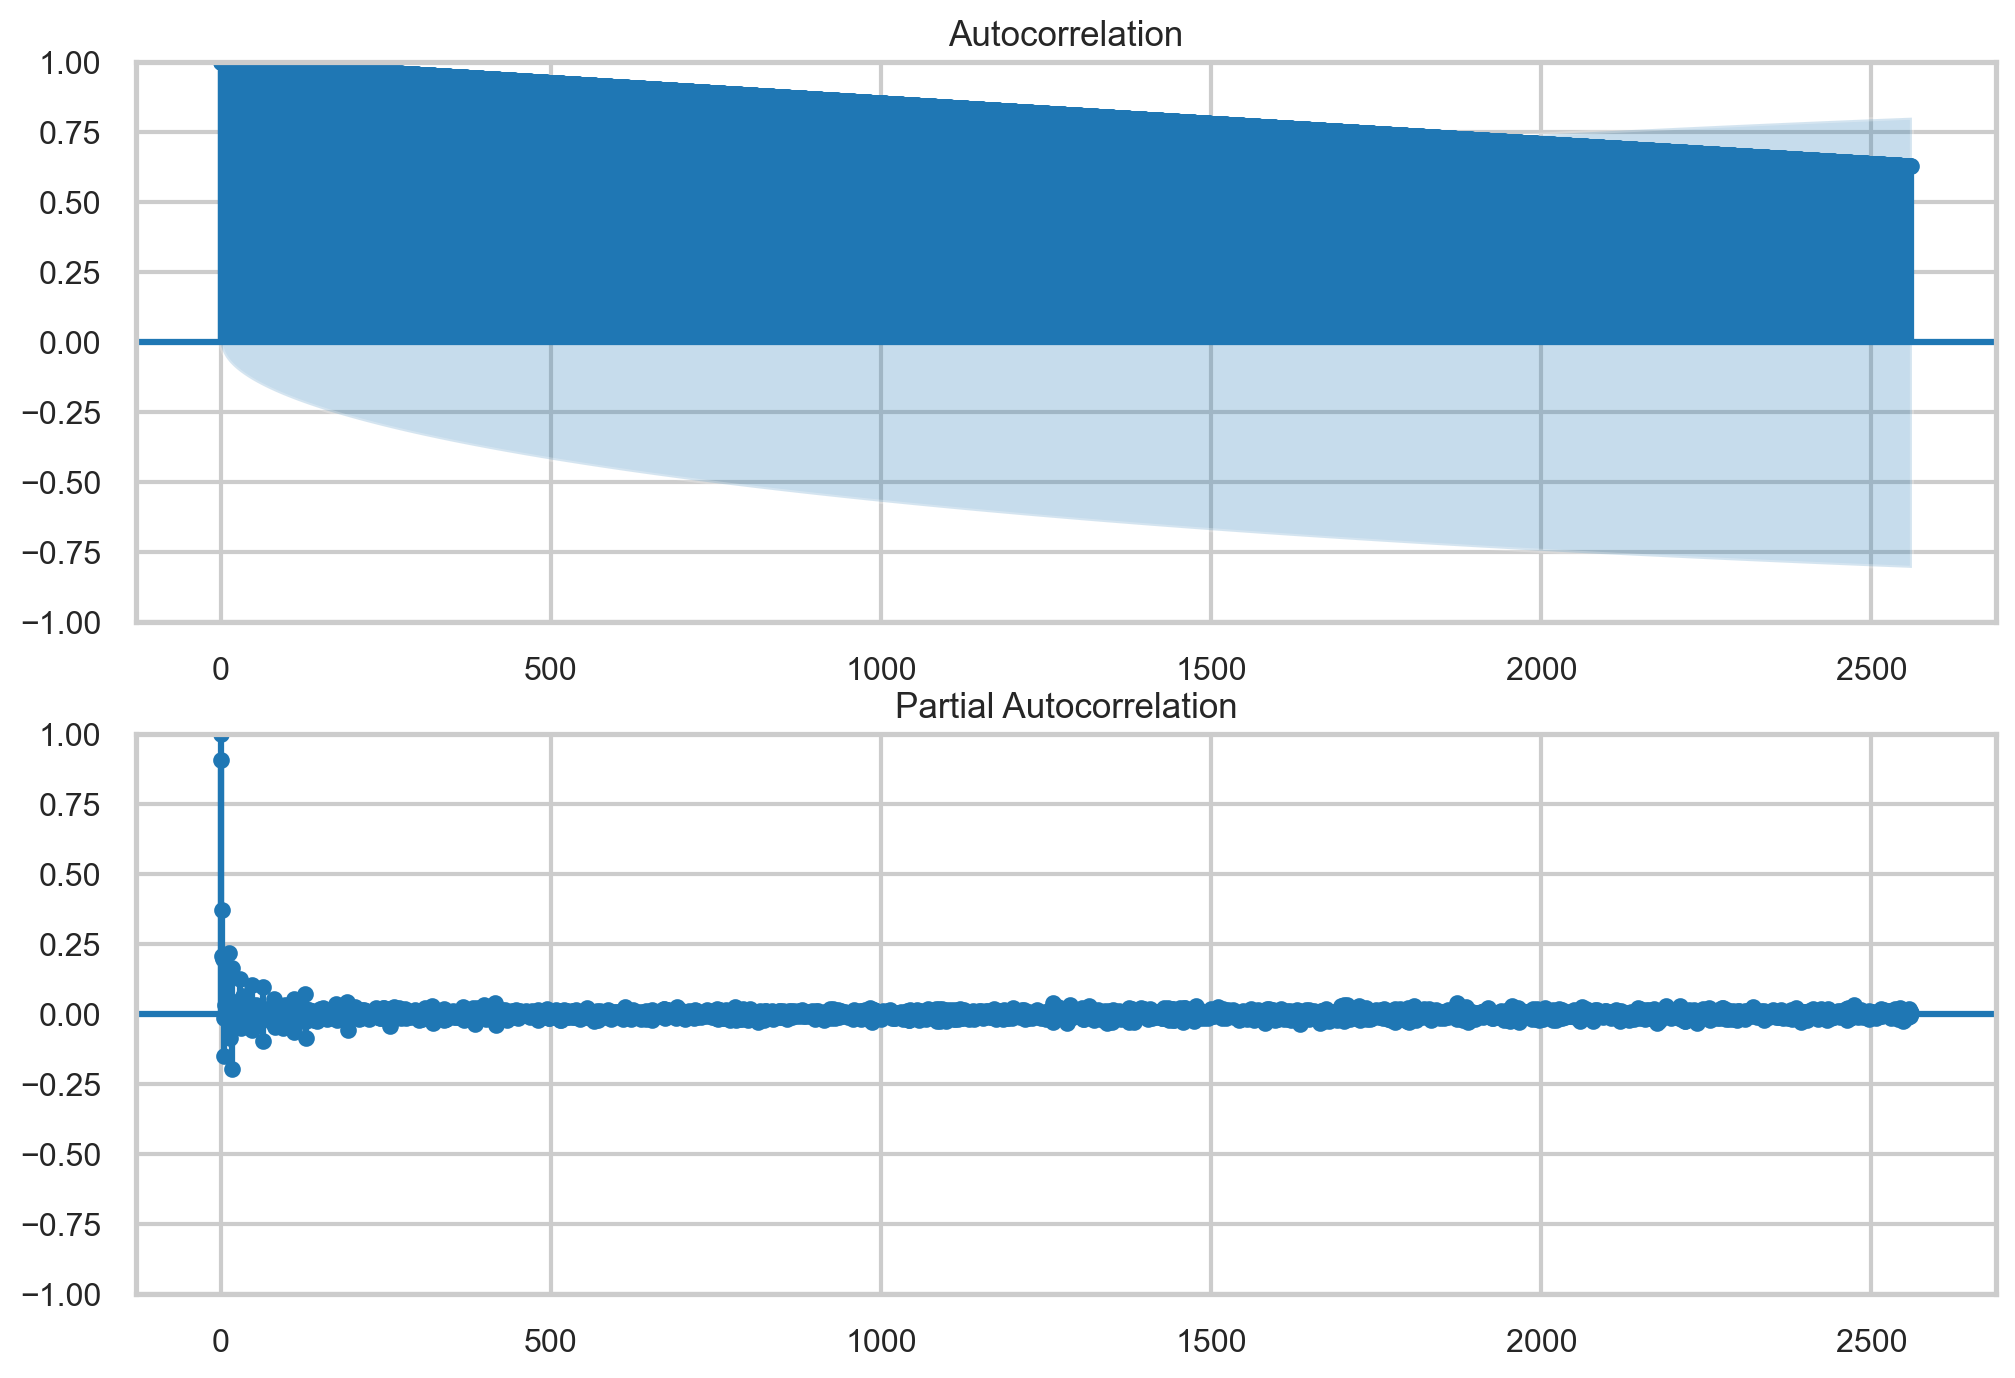

In [49]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(check_it, lags=2560, ax=ax1) # 2560 lags is equivalent to 10 seconds ago
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(p1_arma['means'], lags=2560, ax=ax2)
plt.show()

# A quick review for interpreting the above graphs.

https://towardsdatascience.com/time-series-from-scratch-autocorrelation-and-partial-autocorrelation-explained-1dd641e3076f

1. If the ACF plot declines gradually and the PACF drops instantly, use Auto Regressive model.
2. If the ACF plot drops instantly and the PACF declines gradually, use Moving Average model.
3. If both ACF and PACF decline gradually, combine Auto Regressive and Moving Average models (ARMA).
4. If both ACF and PACF drop instantly (no significant lags), it’s likely you won’t be able to model the time series.

# My data
Running the acfs on small lags below 1000 revealed highly correlated data.
Since my pretence is prediction of an upcomg seizure based on the idea of an epileptic having an "aura," it was when I began increasing lag significanlty (10 seconds in this case) that a pattern emerged reflecting number 1 above.

So the model will be Auto Regressive.

I would think this grdual decline would continue were I to go out further, but the time to calculate on the mac was already significant, and if the mac had an internal fan, it was on trying to cool everything down.

In the model however, I will reduce the lags a bit for 1. macbook fan life (lol)  and 2. model run time considering I'm ultimately heading to TensorFlow and TensorFlow Probability in this notebook.

Additionally, it is customary to run tests for aic and bic to determine the best model, but I supplanted that with the above graph.

In [50]:
p1_timeseries = AutoReg(
		p1_arma['means'], # targeting the mean of $\mu$V across each instant of time
		256, # this lag amounts to one second
		trend='n', # there is "no trend" in the model. There is only a baseline and a seizure, not multiple seizures.
		seasonal=False, # I'm pretty sure seizures don't check with the Winter, Spring, Summer, and Fall  for approval
		exog=p1_arma.to_numpy(), # I do want to include all EEG leads for consideration.
		hold_back=None,
		period=None,
		missing='none'
).fit()

In [51]:
# y = model_fit.predict(len(data), len(data)+21)
p1_prediction = p1_timeseries.predict(
		len(p1_arma.iloc[:10241]),
		len(p1_arma.iloc[:10241]) + 30,
		exog=p1_arma.to_numpy(),
        exog_oos=p1_arma.to_numpy())

In [52]:
p1_compare = pd.concat([p1_copy['means'].iloc[10230:10272], p1_prediction, p1_.iloc[10241:10272, -1]], axis=1)
p1_compare.rename({1:'predicted means', 'means': 'acutal means'}, axis=1, inplace=True)
p1_compare

,acutal means,0,T8-P8-1
10230,15.681441,NaN,NaN
10231,17.641234,NaN,NaN
10232,20.042291,NaN,NaN
10233,22.859074,NaN,NaN
10234,25.711758,NaN,NaN
10235,28.603973,NaN,NaN
10236,31.278927,NaN,NaN
10237,33.090470,NaN,NaN
10238,34.097085,NaN,NaN
10239,34.827357,NaN,NaN


Time Series Model Determination

Column 1 and 3 are identically names but not identical.
Column 1 is there for the purpose of showing values leading up to the seizure.
Column 2 is the predictions.
Column 3 is the actual values next to the predictions.

And it's clear that the predictions are awful, and I expected that to be the case since there is no predicting the sudden collapse of energy at 10240.

# Tensorflow Basic Linear Regression NN

Now I'll run an "out of the box" TensorFlow regression model.

"Out of the box" means the keras.layers.Dense is the standard, easy-peasy, no-frills hidden layer with the desired nodes, and that which makes it a Linear Regression model is the choice of loss functions coupled with the desired output.

A simple regression would map an x-value to a y_value; therefore, the NN model would require a final node equal to 1.
The idea generalizes to higher dimensions.
This model is asking for a prediction on 23 readings from the EEG leads; therefore, the final output layer will be 23.
The loss function will be the stadard mean-squared_error.

Note: I did vary the hyperparameters (number of layers, activation functions, and optimizer type) and nothing yielded better results than below.

The goal below is to train on patient one's baseline as the X and her seizure as the y and then predict patient 18 and the vns seizure values from their respective baselines. I don't expect this to be a successfull model since the brain isn't linear, but the model is here for due diligence and a just-in-case-I-got-lucky intervention from the cosmos.

In [53]:
# define the model and execution because I will vary the X and y a couple of more times to cover possible edge cases.

def tf_sequential_linear_model(X,y,pred18,predvns):
	p = Sequential()
	p.add(layers.Dense(1000,activation='relu',dtype=DTYPE,input_dim=p1_tensor.shape[1]))
	p.add(layers.Dense(500,activation='relu',dtype=DTYPE))
	p.add(layers.Dense(100,activation='relu',dtype=DTYPE))
	p.add(layers.Dense(69,activation='relu',dtype=DTYPE))
	p.add(layers.Dense(46,activation='relu',dtype=DTYPE))
	p.add(layers.Dense(23,dtype=DTYPE))

	# print(plot_model(p, "p.png", show_shapes=True))

	# Define early_stopping_monitor
	early_stopping_monitor = EarlyStopping(monitor='mae',patience=2)

	# compile the model
	p.compile(
			loss=losses.mean_absolute_error,
			metrics=['mae'],
			optimizer=tf.keras.optimizers.Adam(),
			steps_per_execution=None,
			jit_compile=True)

	# Fit the model
	p.fit(
			X,
			y,
			epochs=60,
			callbacks=[early_stopping_monitor],
			verbose=1)

	# Using model.fit() followed by model.evaluate() in the same cell run returns empty History object

	# Evaluate the model
	p1_eval = p.evaluate(
			x=X,
			y=y,
			batch_size=None,
			verbose=1,
			sample_weight=None,
			steps=None,
			callbacks=[early_stopping_monitor],
			max_queue_size=10,
			workers=1,
			use_multiprocessing=False,
			return_dict=True)

	# predict the seizures from the other two patients.
	predict_18 = p.predict(pred18)
	predict_vns = p.predict(predvns)

	# return the model evaluation, and the 2 predictions
	return p1_eval,predict_18,predict_vns

Run the model on the two datasets.

Note that the baseline dataset ends with a very high value and the first values of the seizure dataset begin with a very low value. There is no way for the model to predict this.

Below are those two lines.

In [54]:
demonstration = p1_.iloc[10239:10241]
demonstration.index = ['final baseline value', 'first seizure value']
demonstration

,FP1-F7,F7-T7,T7-P7,P7-O1,FP1-F3,F3-C3,C3-P3,P3-O1,FP2-F4,F4-C4,...,F8-T8,T8-P8-0,P8-O2,FZ-CZ,CZ-PZ,P7-T7,T7-FT9,FT9-FT10,FT10-T8,T8-P8-1
final baseline value,35.425091,34.49116,30.692781,32.991932,40.47344,35.438399,33.964128,33.199653,42.413717,37.865077,...,35.833894,31.098121,31.75015,36.236319,36.485697,30.692781,34.848866,34.504325,34.627743,31.098121
first seizure value,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [55]:
# run the model
p1eval,\
	p18_pred,\
	vns_pred = tf_sequential_linear_model(
		X=p1_Xtensor.numpy(),
		y=p1_ytensor.numpy(),
		pred18=p18_Xtensor,
		predvns=vns_Xtensor)

Epoch 1/60


2022-12-12 22:27:08.820866: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f94c9090c30 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-12-12 22:27:08.822147: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Host, Default Version
2022-12-12 22:27:08.829892: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-12 22:27:09.063756: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


 13/320 [>.............................] - ETA: 2s - loss: 0.3280 - mae: 0.3280

2022-12-12 22:27:10.588503: I tensorflow/compiler/jit/xla_compilation_cache.cc:476] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


320/320 [==============================] - 4s 6ms/step - loss: 0.3420 - mae: 0.3420
Epoch 2/60
320/320 [==============================] - 2s 6ms/step - loss: 0.3337 - mae: 0.3337
Epoch 3/60
320/320 [==============================] - 2s 6ms/step - loss: 0.3262 - mae: 0.3262
Epoch 4/60
320/320 [==============================] - 2s 6ms/step - loss: 0.3176 - mae: 0.3176
Epoch 5/60
320/320 [==============================] - 2s 6ms/step - loss: 0.3094 - mae: 0.3094
Epoch 6/60
320/320 [==============================] - 2s 6ms/step - loss: 0.3003 - mae: 0.3003
Epoch 7/60
320/320 [==============================] - 2s 6ms/step - loss: 0.2928 - mae: 0.2928
Epoch 8/60
320/320 [==============================] - 2s 6ms/step - loss: 0.2753 - mae: 0.2753
Epoch 9/60
320/320 [==============================] - 2s 6ms/step - loss: 0.2672 - mae: 0.2672
Epoch 10/60
320/320 [==============================] - 2s 7ms/step - loss: 0.2527 - mae: 0.2527
Epoch 11/60
320/320 [==============================] - 2s 6m

In [56]:
p1eval

{'loss': 0.1298057734966278, 'mae': 0.1298057734966278}

Take a look see at the p18 predictions, but first a reminder of what the values should be.

In [57]:
p18Seize_y.iloc[:5,:5]

,FP1-F7,F7-T7,T7-P7,P7-O1,FP1-F3
0,-0.531133,-0.566187,-0.531881,-0.579764,-0.570148
1,20.368768,23.467971,28.781255,29.390155,23.256041
2,19.534458,22.552289,26.745151,27.522362,21.259236
3,18.541878,21.266972,24.257782,25.043927,19.096833
4,17.714797,19.835811,21.933831,22.484131,17.650779


And the predictions

In [58]:
p18_pred[:5,:5]

array([[ 1.61304919,  1.0159112 ,  0.97438004,  1.67636483,  1.25481246],
       [ 1.51852991,  0.95185343,  0.82889113,  1.27608216,  1.09954988],
       [ 0.76149711,  0.54312996,  0.7076086 ,  0.71114003,  0.74177313],
       [-0.24853196, -0.33100199, -0.23936661, -0.25549541, -0.26104182],
       [-0.41509425, -0.33265651, -0.14984968, -0.03104797, -0.36851871]])

Not even close. Let's subtract them cell by cell and take the absolute value to see how far off.
Were the model accurate, these differences would be close to zero.

In [59]:
p18_compare = abs(p18_pred[:5,:3] - p18_ytensor[:5,:3])
vns_compare = abs(vns_pred[:5,:3] - vns_ytensor[:5,:3])
print(p18_compare)
print()
print(vns_compare)

[[ 2.14418232  1.58209815  1.50626059]
 [18.85023769 22.51611743 27.95236411]
 [18.77296113 22.00915936 26.03754206]
 [18.79041037 21.59797389 24.49714839]
 [18.12989135 20.16846711 22.08368061]]

[[ 0.25651408  0.41458129  0.9364276 ]
 [38.11284853 39.26632062 38.32853142]
 [31.52063829 32.96294844 31.99880977]
 [23.67155692 24.91930079 24.31659687]
 [16.964106   16.85347572 16.91325826]]


Mentioned earlier, maybe X-train has no way to recognize the sudden drop in uV at the seizure y-train.
I will put that row in X-train and reformat the two datasets to keep things equal via...

Remove 1st two rows from X-train and add one row (the first row of y-train) to end of X-train then...
Remove last row from y, keeping dimensions accurate.

I'll write a function becuase I'll do it more than once.

In [60]:
def moving_seizure_rows_or_columns(df,
                                   rowStartX=None,rowEndX=None,
                                   rowStarty=None,rowEndy=None):

	p_X = tf.Variable(df.iloc[rowStartX:rowEndX],dtype=DTYPE).numpy()
	p_y = tf.Variable(df.iloc[rowStarty:rowEndy],dtype=DTYPE).numpy()

	return p_X,p_y

In [61]:
p1_X_with_SeizureStart,\
	p1_y_without_SeizureStart = \
	moving_seizure_rows_or_columns(p1_,
                                    rowStartX=2,
                                    rowEndX=10241,
                                    rowStarty=10241)
p18_X_with_SeizureStart,\
	p18_y_without_SeizureStart = \
	moving_seizure_rows_or_columns(p18_,
                                    rowStartX=2,
                                    rowEndX=10241,
                                    rowStarty=10241)
vns_X_with_SeizureStart,\
	vns_y_without_SeizureStart = \
	moving_seizure_rows_or_columns(vns_,
                                    rowStartX=2,
                                    rowEndX=10241,
                                    rowStarty=10241)

In [62]:
updated_p1_X_with_SeizureStart, \
	update_p18Pred, \
	update_vnsPred = \
	tf_sequential_linear_model(
			X=p1_X_with_SeizureStart,
			y=p1_y_without_SeizureStart,
			pred18=p18_X_with_SeizureStart,
			predvns=vns_X_with_SeizureStart)

Epoch 1/60
320/320 [==============================] - 4s 8ms/step - loss: 0.1792 - mae: 0.1792
Epoch 2/60
320/320 [==============================] - 2s 6ms/step - loss: 0.1727 - mae: 0.1727
Epoch 3/60
320/320 [==============================] - 2s 6ms/step - loss: 0.1739 - mae: 0.1739
Epoch 4/60
320/320 [==============================] - 1s 2ms/step


I will jump straight to the differences this time and they are certainly not near zero.

In [63]:
updated_p18_compare = abs(update_p18Pred[:5,:3] - p18_y_without_SeizureStart[:5,:3])
updated_vns_compare = abs(update_vnsPred[:5,:3] - vns_y_without_SeizureStart[:5,:3])
print(updated_p18_compare)
print()
print(updated_vns_compare)

[[20.3688671  23.46779414 28.78116523]
 [19.53455774 22.5521126  26.74506066]
 [18.54197791 21.26679518 24.25769178]
 [17.7148966  19.83563389 21.93374093]
 [17.16772063 18.39777398 20.03277182]]

[[37.96121079 38.92926713 38.29172628]
 [31.44729498 32.84858337 32.17501303]
 [23.67174756 24.80509475 24.30928288]
 [17.21986606 16.81733553 16.81066748]
 [13.18521563 10.21773512 10.8649923 ]]


This time I'll go deeper into y-train and extract several of its first rows to put at the end of X-train.

In [64]:
p1_X_with_SeizureStart_plus1,\
	p1_y_without_SeizureStart_minus1 = \
	moving_seizure_rows_or_columns(
		p1_,
		rowStartX=4,
		rowEndX=10242,
		rowStarty=10242)

p18_X_with_SeizureStart_plus1,\
	p18_y_without_SeizureStart_minus1 = \
	moving_seizure_rows_or_columns(
		p18_,
		rowStartX=4,
		rowEndX=10242,
		rowStarty=10242)

vns_X_with_SeizureStart_plus1,\
	vns_y_without_SeizureStart_minus1 = \
	moving_seizure_rows_or_columns(
		vns_,
		rowStartX=4,
		rowEndX=10242,
		rowStarty=10242)

updated_p1_X_with_SeizureStart_plus1, \
	update_p18Pred_plus1, \
	update_vnsPred_plus1 = \
	tf_sequential_linear_model(
			X=p1_X_with_SeizureStart_plus1,
			y=p1_y_without_SeizureStart_minus1,
			pred18=p18_X_with_SeizureStart_plus1,
			predvns=vns_X_with_SeizureStart_plus1)

Epoch 1/60
320/320 [==============================] - 4s 8ms/step - loss: 0.1764 - mae: 0.1764
Epoch 2/60
320/320 [==============================] - 2s 6ms/step - loss: 0.1695 - mae: 0.1695
Epoch 3/60
320/320 [==============================] - 2s 6ms/step - loss: 0.1695 - mae: 0.1695
Epoch 4/60
320/320 [==============================] - 1s 2ms/step


In [65]:
updated_plus1_p18_compare = abs(update_p18Pred_plus1[:5,:3] - p18_y_without_SeizureStart_minus1[:5,:3])
updated_plus1_vns_compare = abs(update_vnsPred_plus1[:5,:3] - vns_y_without_SeizureStart_minus1[:5,:3])
print(updated_plus1_p18_compare)
print()
print(updated_plus1_vns_compare)

[[19.53441229 22.55211918 26.74416083]
 [18.54183246 21.26680176 24.25679195]
 [17.71475115 19.83564047 21.9328411 ]
 [17.16757518 18.39778057 20.03187199]
 [16.78195377 16.98744509 18.33597032]]

[[31.44714953 32.84858996 32.17411321]
 [23.67160211 24.80510134 24.30838306]
 [17.21972061 16.81734212 16.80976765]
 [13.18507018 10.21774171 10.86409247]
 [10.98090228  5.33575845  6.46976725]]


Nope!
The differences should be near zero.
The cosmos held fast with it's non-linearity.

Ont the two TensorFlow  models that I hope are more successful.

# TensorFlow RNN via LSTM

The following tensors were designed to see if troubles with LSTM predictions could have been related to the lengthy cell states carried through the cell layers.

Furthermore, the lengths of all sets had to be equal for model fitting.

In [66]:
# p1's reduced tensors.
p1_Xgt_0point1, p1_ygt = where_uV_gt_oh_point_1(p1Base_X, p1Seize_y)
p1_Xgt_0point1_tensor, p1_ygt_tensor = \
	tf.Variable(p1_Xgt_0point1, dtype=DTYPE, name='p1_Xgt_Opoint1'), \
		tf.Variable(p1_ygt, dtype=DTYPE, name='p1_ygt')

# p1b's reduced tensors.
p18_Xgt_0point1, p18_ygt = p18Base_X.iloc[8896:], p18Seize_y[8896:]
p18_Xgt_0point1_tensor, p18_ygt_tensor = \
	tf.Variable(p18_Xgt_0point1, dtype=DTYPE, name='p18_Xgt_0point1'), \
		tf.Variable(p18_ygt, dtype=DTYPE, name='p18_ygt')

# vns's reduced tensors.
vns_Xgt_0point1, vns_ygt = vnsBase_X.iloc[8896:], vnspSeize_y[8896:]
vns_Xgt_0point1_tensor, vns_ygt_tensor = \
	tf.Variable(vns_Xgt_0point1, dtype=DTYPE, name='vns_Xgt_0point1'), \
		tf.Variable(vns_ygt, dtype=DTYPE, name='vns_ygt')

Since the early predictions with the entire dataset weren't accurate and I felt as though there were too many rows under the 75th percentile and that were hurting the model, I reduced the rows above.
Let's remind ourselves how huge this gap is.

In [67]:
its_crazy_far = p1Base_X.describe().iloc[:,0]
its_crazy_far

count    1.024000e+04
mean     1.110223e-17
std      1.000000e+00
min     -1.874910e-01
25%     -1.432243e-01
50%     -9.130100e-02
75%     -2.724956e-02
max      3.542509e+01
Name: FP1-F7, dtype: float64

In [68]:
print(f"Distance from max value back to 7th percentile:\n{its_crazy_far.iloc[-1] - its_crazy_far.iloc[-2]}")
print('--------------------------------')
print(f"And for comparison, the distance from 75th percentile way back to the minimum:\n{its_crazy_far.iloc[-2] - its_crazy_far.iloc[1]} ")

Distance from max value back to 7th percentile:
35.45234044023687
--------------------------------
And for comparison, the distance from 75th percentile way back to the minimum:
-0.027249555684906 


That's no typo.
The distance from the minimum to the 75th percentile is basically zero.

Even worse: the jump comes basically within the last few seconds of the entire dataset.

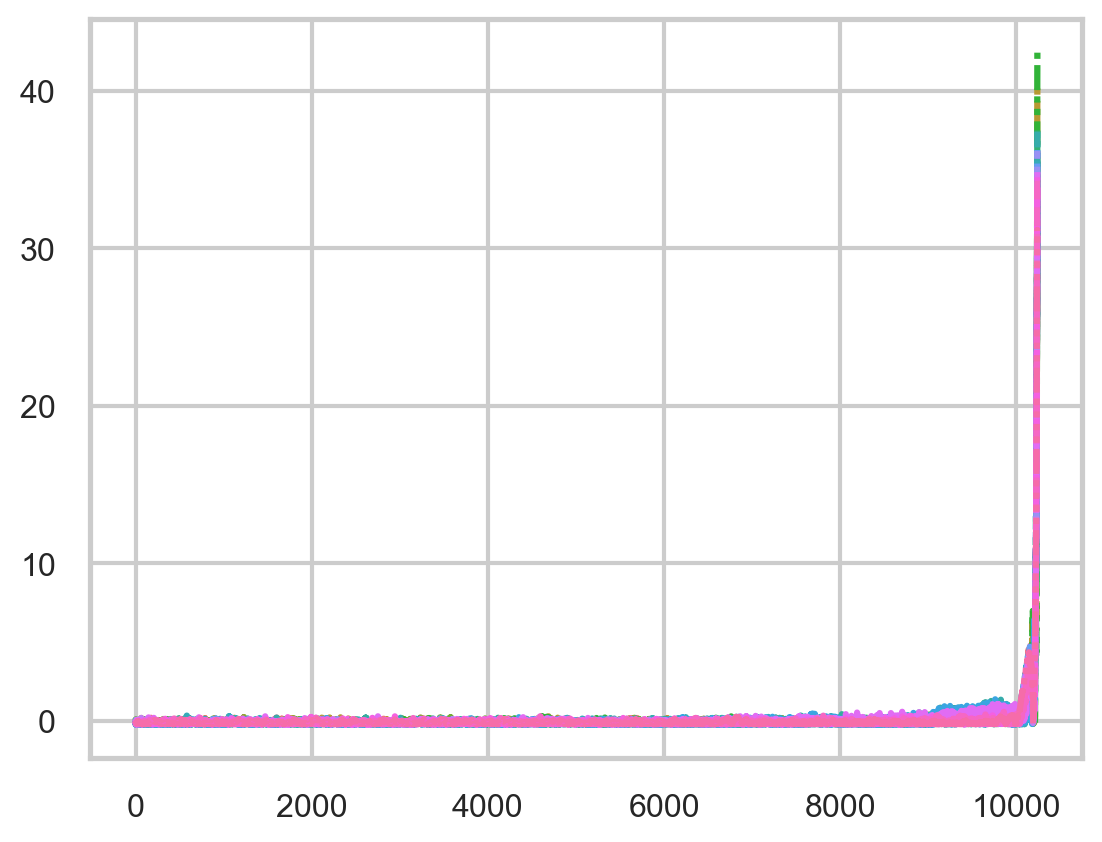

In [69]:
sns.lineplot(data=p1Base_X, legend=False)
plt.show()

That wasn't promising; hence, I created the reduced-sized datasets to give the LSTM less really low values to remember through its cell state.

All values in this set are above 0.1. there were no values below this leading up to the seizure.

Now it looks like the graph below, and still, the majority of the large values are at the end.

This graph starts about 4 seconds before the seizure. The first large leap is around one second before the seizure.

I think this graph shows how unpredictable and difficult this problem is. It all happens so fast.

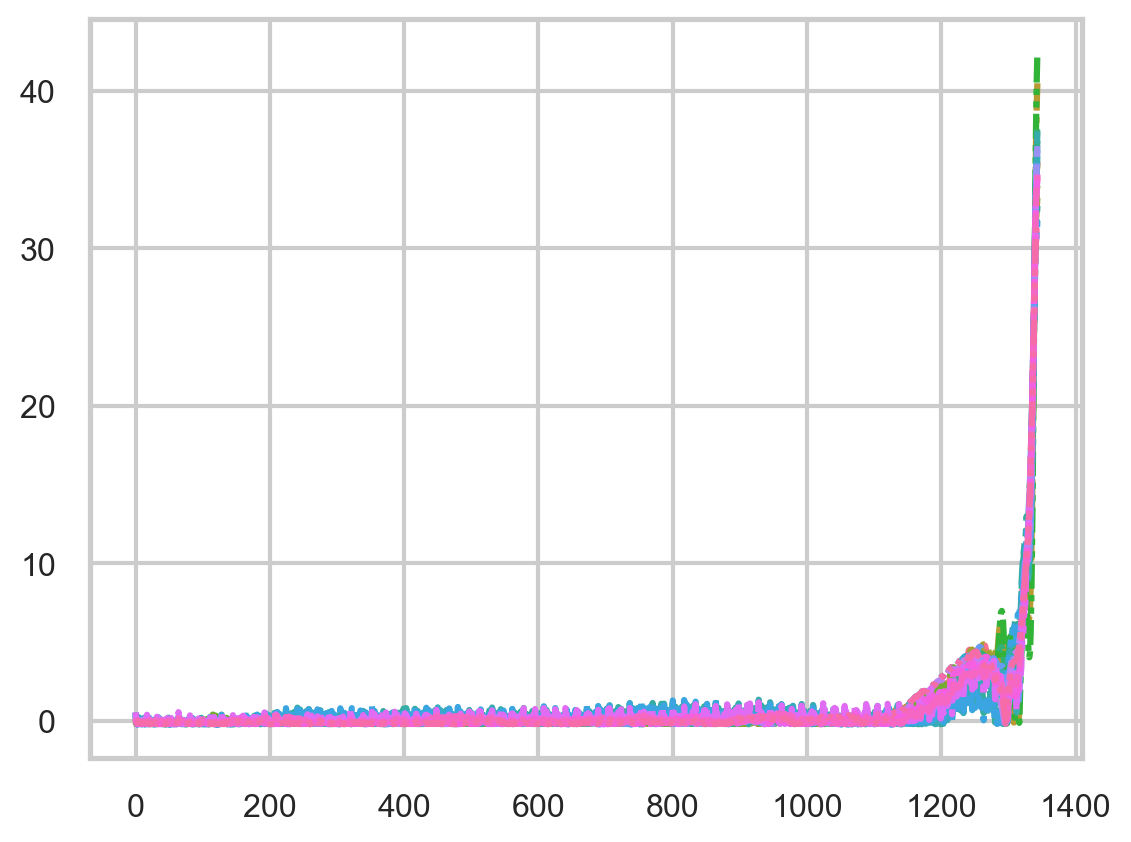

In [70]:
sns.lineplot(data=p1_Xgt_0point1, legend=False)
plt.show()

LSTM is moody with its tensor shape, and quite frankly, it took a couple of days to really get a handle on it.

LSTM requires an input shape: [batch shape, timesteps, features]

Batch_size is basically the entire length of the dataset divided by some integer.
By default, any RNN layer resets it's state to zero after an epoch is one. For LSTM (Long Short Term Memory) to have Long Term Memory, these states must be carried forward. The good news is that this is done with hyperparameters in the call to the LSTM layer. There are comments in the code below where these crucial hyperparameters must be set.
The batch can be 1, meaning the entire dataset, or it can be the number of rows in the dataset (not recommended, it crashed my machine).

Timesteps is the number of rows in a batch_size. The best way to remember this is to remember there is sort of an inverse relationship between timesteps and batch_size. The higher the number of batches, the lower the number of timesteps.
If batch_size is 1 (meaning the length of the dataset) then the timesteps is equal to the length of the dataframe.
If the batch_size is 2 (the length of the dataset halved), then timesteps is equal to the half the length of dataframe.

Finally, something simple, features is just what it says it is. The number of features is the number of feature.

The idea in the next cell is to create an iterable list of tuples, each of which contains a derivation of the LSTM required input_shape = [batch_size, timesteps, features] with varying numbers of batch_sizes.

The plan is to iterate over the list and run the model on all of them to see which is best.

In [71]:
batches_reduced_df = [1, 2, 3, 4, 6, 7, 8, 12]
timesteps_reduced_df = [int(1344 / i) for i in batches_reduced_df]
input_shapes_reduced = [(i, j, 23) for i, j in zip(batches_reduced_df, timesteps_reduced_df)]
input_shapes_reduced  # (batch_size, timesteps, features)

[(1, 1344, 23),
 (2, 672, 23),
 (3, 448, 23),
 (4, 336, 23),
 (6, 224, 23),
 (7, 192, 23),
 (8, 168, 23),
 (12, 112, 23)]

In [72]:
# define the model
def lstm(X, y, inputshape):
	mean = tf.cast(tf.reduce_mean(X), dtype=tf.float32)
	std = tf.cast(tf.math.reduce_std(X), dtype=tf.float32)
	initializer = initializers.RandomNormal(mean=mean, stddev=std, seed=1) # create a bias starting near real data
	lstm_model = Sequential()
	lstm_model.add(layers.LSTM(
			batch_input_shape=inputshape,
			# input_shape=(10240, 23),
			units=23,  # output dimensionality is the number of features I'm predicting: one for each EEG lead.
			activation='tanh',  # keeps values between near 0 and near 1. Also eliminats vanishing gradient problem.
			recurrent_activation='sigmoid',  # responsible for deciding how much new info to add to cell
			use_bias=True,  # always The bias eliminates zeros being sent forward. We do not want this.
			kernel_initializer='glorot_uniform',  # random distributions for initial weights in layer
			recurrent_initializer='orthogonal',  # same as above but takes place in the cell with recurrent activation
			bias_initializer=initializer,  # where it starts
			unit_forget_bias=False,
			kernel_regularizer=None,  # Tries to reduce the weights
			recurrent_regularizer=None,  # same as kernel but in the cell
			bias_regularizer=None,  # tries to reduce the bias
			activity_regularizer=None,  # Tries to reduce the layer's output
			kernel_constraint=None,
			recurrent_constraint=None,
			bias_constraint=None,
			dropout=0.2,
			recurrent_dropout=0.2,
			return_sequences=True,  # must be True when stacking layers and wanting to take value of each timestep
			return_state=False,  # if true, this will output a multidimensional tensor and funcitonal API is required
			go_backwards=False,
			stateful=True,  # I want the previous output to be the input for the next.
			time_major=False,
			unroll=False))

	lstm_model.add(layers.LSTM(
			batch_input_shape=inputshape,
			# input_shape=(10240, 23),
			units=23,  # output dimensionality
			activation='tanh',  # keeps values between near zero and near 1
			recurrent_activation='sigmoid',  # responsible for deciding how much new info to add to cell
			use_bias=True,  # always
			kernel_initializer='glorot_uniform',  # random distributions for initial weights in layer
			recurrent_initializer='orthogonal',  # same as above but takes place in the cell with recurrent activation
			bias_initializer=initializer,  # where it starts
			unit_forget_bias=False,
			kernel_regularizer=None,  # Tries to reduce the weights
			recurrent_regularizer=None,  # same as kernel but in the cell
			bias_regularizer=None,  # tries to reduce the bias
			activity_regularizer=None,  # Tries to reduce the layer's output
			kernel_constraint=None,
			recurrent_constraint=None,
			bias_constraint=None,
			dropout=0.2, # dropping a percentage of the data randomly is said to be good to avoid overfitting.
			recurrent_dropout=0.2, # same as previous.
			return_sequences=True,  # must be True when stacking layers and wanting to take values to next timestep
			return_state=False,  # if true, this will output a multidimensional tensor and funcitonal API is required
			go_backwards=False,
			stateful=True,  # I want the previous output to be the input for the next.
			time_major=False,
			unroll=False))

	lstm_model.add(layers.Dense(23))  # for the final output.

	# print some info for debugging when needed.
	print(lstm_model.summary())
	print(lstm_model.output)

	# compile the model
	lstm_model.compile(
			loss='mean_absolute_percentage_error',
			metrics=['mean_absolute_percentage_error'],
			optimizer=tf.keras.optimizers.Adam(),
			steps_per_execution=None,
			jit_compile=True)

	# early_stopping_monitor = EarlyStopping(monitor='mean_absolute_percentage_error', patience=3)

	# Fit the model
	lstm_model.fit(X, y,
			epochs=2000, # 2000 forward and backward passes through the batches.
			# callbacks=[early_stopping_monitor],
			verbose=0 # 0 so 2000 lines don't print
				   )

	return lstm_model

In [73]:
lstm1 = lstm(
		tf.reshape(p1_Xgt_0point1_tensor, input_shapes_reduced[0]),
		tf.reshape(p1_ygt_tensor, input_shapes_reduced[0]),
		inputshape=input_shapes_reduced[0])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (1, 1344, 23)             4324      
                                                                 
 lstm_1 (LSTM)               (1, 1344, 23)             4324      
                                                                 
 dense_18 (Dense)            (1, 1344, 23)             552       
                                                                 
Total params: 9,200
Trainable params: 9,200
Non-trainable params: 0
_________________________________________________________________
None
KerasTensor(type_spec=TensorSpec(shape=(1, 1344, 23), dtype=tf.float32, name=None), name='dense_18/BiasAdd:0', description="created by layer 'dense_18'")


2022-12-12 22:29:18.802319: W tensorflow/compiler/tf2xla/kernels/random_ops.cc:57] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. sequential_3/lstm/lstm_cell/dropout/random_uniform/RandomUniform


In [74]:
# let's take a look at the loss at the end of all epochs. Should be near zero.
lstm1.history.history['loss'][-5:]

[101.6162338256836,
 101.44115447998047,
 102.12007141113281,
 102.91836547851562,
 102.40734100341797]

Doh! Not good.

In [75]:
# predict the seizures from the other two patients.
predict_18 = lstm1.predict(tf.reshape(p18_Xgt_0point1_tensor, input_shapes_reduced[0]))
predict_vns = lstm1.predict(tf.reshape(vns_Xgt_0point1_tensor, input_shapes_reduced[0]))

1/1 [==============================] - 0s 20ms/step


Predict p18 and take a look at the top left corner.

In [76]:
eighteen = tf.squeeze(tf.reshape(predict_18, input_shapes_reduced[0]).numpy())
eighteen_df = pd.DataFrame(eighteen)
eighteen_df.iloc[:5,0]

0   -0.065416
1   -0.050488
2   -0.028348
3   -0.013180
4   -0.005519
Name: 0, dtype: float32

And the top left corner of the actual values.

In [77]:
p18Seize_y.iloc[:5,0]

0    -0.531133
1    20.368768
2    19.534458
3    18.541878
4    17.714797
Name: FP1-F7, dtype: float64

Doh!! Not even close.

How about the VNS patient?

In [78]:
vns = tf.squeeze(tf.reshape(predict_vns, input_shapes_reduced[0]).numpy())
vns_df = pd.DataFrame(vns)
# predictions
vns_df.iloc[:5,0]

0   -0.077849
1   -0.065053
2   -0.040734
3   -0.021084
4   -0.010259
Name: 0, dtype: float32

In [79]:
# actuals.
vnspSeize_y.iloc[:5,0]

0    -0.592201
1    37.961111
2    31.447195
3    23.671648
4    17.219767
Name: FP1-F7, dtype: float64

No bueno.

Let's go to the other extreme of the batch shape and break them up.

In [80]:
lstm2 = lstm(
		X=tf.reshape(p1_Xgt_0point1_tensor, input_shapes_reduced[-1]),
		y=tf.reshape(p1_ygt_tensor, input_shapes_reduced[-1]),
		inputshape=input_shapes_reduced[-1])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (12, 112, 23)             4324      
                                                                 
 lstm_3 (LSTM)               (12, 112, 23)             4324      
                                                                 
 dense_19 (Dense)            (12, 112, 23)             552       
                                                                 
Total params: 9,200
Trainable params: 9,200
Non-trainable params: 0
_________________________________________________________________
None
KerasTensor(type_spec=TensorSpec(shape=(12, 112, 23), dtype=tf.float32, name=None), name='dense_19/BiasAdd:0', description="created by layer 'dense_19'")


In [81]:
# predict the seizures from the other two patients.
predict_18_2 = lstm2.predict(tf.reshape(p18_Xgt_0point1_tensor, input_shapes_reduced[-1]))
predict_vns_2 = lstm2.predict(tf.reshape(vns_Xgt_0point1_tensor, input_shapes_reduced[-1]))

1/1 [==============================] - 0s 18ms/step


In [82]:
eighteen_2 = tf.squeeze(tf.reshape(predict_18_2, input_shapes_reduced[0]).numpy())
eighteen_df_2 = pd.DataFrame(eighteen_2)
eighteen_df_2.iloc[:5,0]

0   -0.001054
1   -0.001276
2   -0.001512
3   -0.001813
4   -0.002032
Name: 0, dtype: float32

In [83]:
p18Seize_y.iloc[:5,0]

0    -0.531133
1    20.368768
2    19.534458
3    18.541878
4    17.714797
Name: FP1-F7, dtype: float64

In [84]:
vns_2 = tf.squeeze(tf.reshape(predict_vns, input_shapes_reduced[0]).numpy())
vns_df_2 = pd.DataFrame(vns_2)
vns_df_2.iloc[:5,0]

0   -0.077849
1   -0.065053
2   -0.040734
3   -0.021084
4   -0.010259
Name: 0, dtype: float32

In [85]:
vnspSeize_y.iloc[:5,0]

0    -0.592201
1    37.961111
2    31.447195
3    23.671648
4    17.219767
Name: FP1-F7, dtype: float64

It's clear that it will not be necessary to iterate through the batch_shapes to see which model is best if the two ends in the list are equally awful.

I had such hope for this model, but I continue to forget hope is a dangerous concept. It's so easily crushed.

Why is this model not working?

I finally realized the major fault with this method, and alot of ML models, the model is predicting a cell in the same location as the cell it was trained on.

A prediction for the first row in the X-train will produce low values in the first row of the y-test.
But it's clear the y-test values are very high compared to the predictions.

The following graph show this pictorially.
The top graph is the X-train and the bottom graph is the y-train.

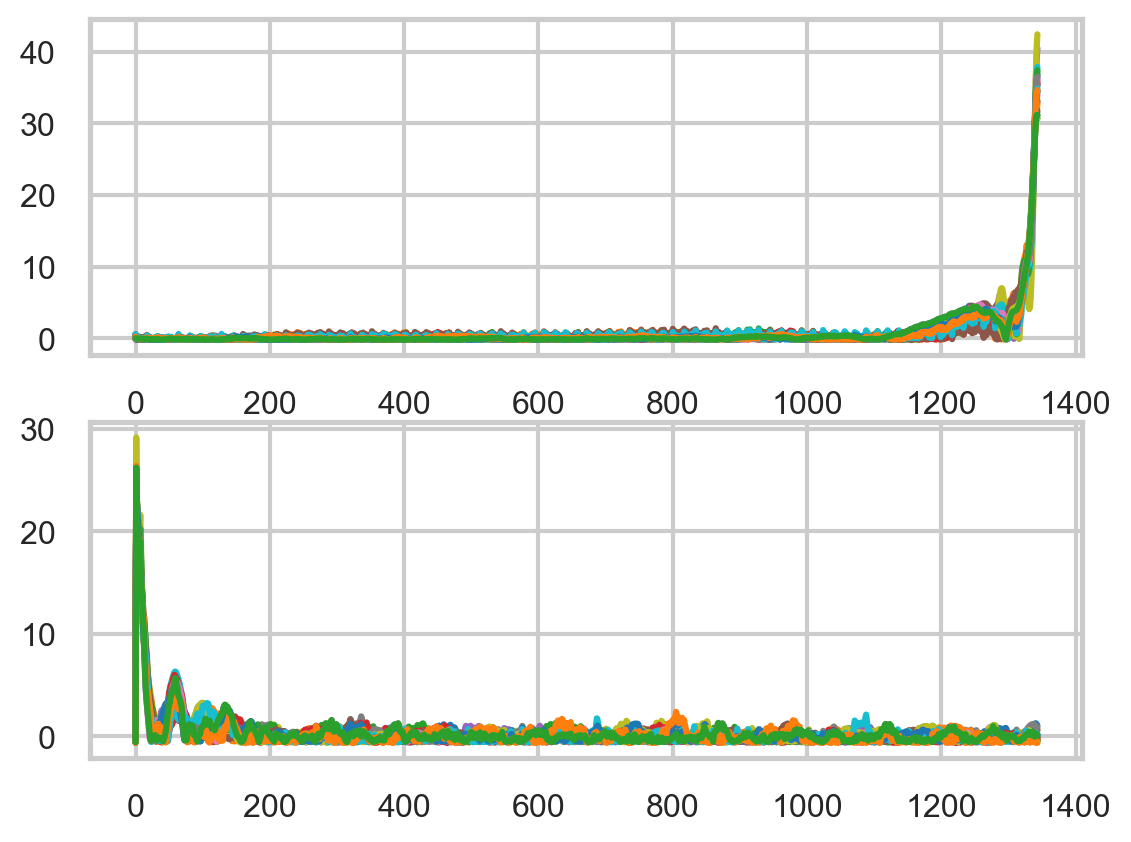

In [86]:
fig, axs = plt.subplots(2,1)
axs[0].plot(p1_Xgt_0point1)
axs[1].plot(p1_ygt)
plt.show()

And the view for the whole dataset gives the full picture (graph in the next cell) when these two graphs are joined together.

The seizure is in the middle, right where I split the datasets.

And it's clear that the values between the two spikes marking the beginning and end of the seizure are different form the values before the seizure.

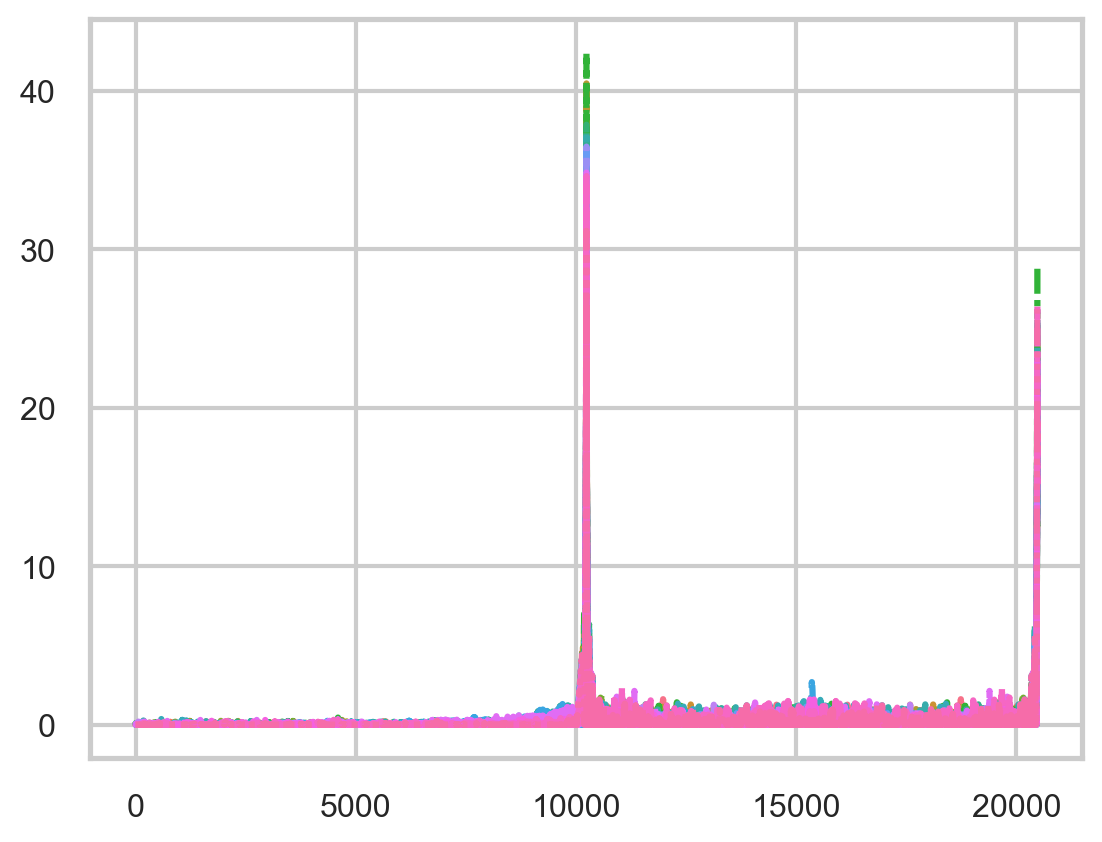

In [87]:
sns.lineplot(data=p1_, legend=False)
plt.show()

Given all of the above information, it's clear all that can come from running models on raw epilepsy EEG data is maybe better understanding of seizure mechanics.

Seizure prediction, per se, would have to come in the following form:

1. Get an EEG of the patient's baseline and seizure to process the values needed to determine when their seizures are imminent. The next time the patient has an EEG...
2. Read the 23 EEG cells in one moment of time
3. Get rid of noise with something like a Fast Fourier
4. When a summary stat drifts over the patient's established uV values,
5. Issue some sort of alert that something is wrong.

WOW. That  would provide some relief to parents with little to no knowledge about what is going on.

So I can do this in a simple for loop.


In [91]:
seizure_potential = {}

# The values 0.1 and 1 come from my Fast Fourier above

for (index, row) in p1_.iterrows():
	if 0.1 < row.mean() < 1:
		print(f'WARNING SEIZURE POTENTIAL NOTICED AT TIME = {index}')
		seizure_potential[index] = 'WARNING SEIZURE POTENTIAL NOTICED AT TIME'
	if 1 <= row.mean() < 10:
		print('--------------------------------------------------------')
		print(f'WARNING SEIZURE LIKELY = {index}')
		seizure_potential[index] = 'WARNING SEIZURE LIKELY'
	if row.mean() > 10:
		print('--------------------------------------------------------')
		print(f'SEIZURE! SEIZURE! = {index}:\n\nvalue: {row.mean()}')
		seizure_potential[index] = 'SEIZURE! SEIZURE! SEIZURE! SEIZURE! SEIZURE! SEIZURE!'


WARNING SEIZURE POTENTIAL NOTICED AT TIME = 8704
WARNING SEIZURE POTENTIAL NOTICED AT TIME = 8896
WARNING SEIZURE POTENTIAL NOTICED AT TIME = 9024
WARNING SEIZURE POTENTIAL NOTICED AT TIME = 9086
WARNING SEIZURE POTENTIAL NOTICED AT TIME = 9090
WARNING SEIZURE POTENTIAL NOTICED AT TIME = 9094
WARNING SEIZURE POTENTIAL NOTICED AT TIME = 9103
WARNING SEIZURE POTENTIAL NOTICED AT TIME = 9107
WARNING SEIZURE POTENTIAL NOTICED AT TIME = 9120
WARNING SEIZURE POTENTIAL NOTICED AT TIME = 9124
WARNING SEIZURE POTENTIAL NOTICED AT TIME = 9137
WARNING SEIZURE POTENTIAL NOTICED AT TIME = 9141
WARNING SEIZURE POTENTIAL NOTICED AT TIME = 9154
WARNING SEIZURE POTENTIAL NOTICED AT TIME = 9158
WARNING SEIZURE POTENTIAL NOTICED AT TIME = 9171
WARNING SEIZURE POTENTIAL NOTICED AT TIME = 9184
WARNING SEIZURE POTENTIAL NOTICED AT TIME = 9201
WARNING SEIZURE POTENTIAL NOTICED AT TIME = 9218
WARNING SEIZURE POTENTIAL NOTICED AT TIME = 9235
WARNING SEIZURE POTENTIAL NOTICED AT TIME = 9248
WARNING SEIZURE POTE

Lets look see at the time around the seizure.
Note that row 10240 is missing because at the start of the seizure, the uVs drop then jump.
This drop marks the official start of the seizure.

In [90]:
for k, v in seizure_potential.items():
	if k > 10210 and k < 10245:
		print(k, '\n', v)

10211 
 WARNING SEIZURE LIKELY
10212 
 WARNING SEIZURE LIKELY
10213 
 WARNING SEIZURE LIKELY
10214 
 WARNING SEIZURE LIKELY
10215 
 WARNING SEIZURE LIKELY
10216 
 WARNING SEIZURE LIKELY
10217 
 WARNING SEIZURE LIKELY
10218 
 WARNING SEIZURE LIKELY
10219 
 WARNING SEIZURE LIKELY
10220 
 WARNING SEIZURE LIKELY
10221 
 WARNING SEIZURE LIKELY
10222 
 WARNING SEIZURE LIKELY
10223 
 SEIZURE! SEIZURE! SEIZURE! SEIZURE! SEIZURE! SEIZURE!
10224 
 SEIZURE! SEIZURE! SEIZURE! SEIZURE! SEIZURE! SEIZURE!
10225 
 SEIZURE! SEIZURE! SEIZURE! SEIZURE! SEIZURE! SEIZURE!
10226 
 SEIZURE! SEIZURE! SEIZURE! SEIZURE! SEIZURE! SEIZURE!
10227 
 SEIZURE! SEIZURE! SEIZURE! SEIZURE! SEIZURE! SEIZURE!
10228 
 SEIZURE! SEIZURE! SEIZURE! SEIZURE! SEIZURE! SEIZURE!
10229 
 SEIZURE! SEIZURE! SEIZURE! SEIZURE! SEIZURE! SEIZURE!
10230 
 SEIZURE! SEIZURE! SEIZURE! SEIZURE! SEIZURE! SEIZURE!
10231 
 SEIZURE! SEIZURE! SEIZURE! SEIZURE! SEIZURE! SEIZURE!
10232 
 SEIZURE! SEIZURE! SEIZURE! SEIZURE! SEIZURE! SEIZURE!
10233 
 

So that was easy.

What follows is speaking as a parent/husband of a severly epileptic daughter/wife that has spent a lot of time in hospitals.

And why don't hospitals just do it like that?

That's a good question. Seems more cost efficient, and definitly seems better for the patient's family.

EMU (Epilepsy Monitoring Unit) in hospitals have these instructions:
	"If you believe she's having a seizure press this button on the machine and get up and write down the time on this seizure tracker."

So if I'm asleep in the hospital and I'm lucky enough that the seizure allows me to wake up (most of my daughters' are silent), I need to jump up, look at her to verify, press a button (which marks the time on the readings), write down the time (a back up I guess), and wait for nurses.

What's all the hubbub with these complicated EEG wave monitors and technolgy to diagnose a seizure when I just demonstrated a seizure alert after running a simple for loop?

How about this set of instructions?
	"If the a soft beeping tone sounds, the computer is saying a seizure could be approaching."
	"If a strong beeping tone sounds, a seizure is imminent and the front desk is notified"
	"If a strong solid tone sounds, your daughter is having a seizure."


# Capstone 2 Conclusion

I set out to find a seizure prediction model using EEG readings, and I ended up maybe proving that's impossible, which probably explains why it's never been done.

It's common knowledge in mathematical circles that Epilepsy falls into the category of Nonlinear dynamics on the continuum with what may as well be considered infinite variables. This branch of mathematics is known to be dominated by chaos, which in a nutshell says prediction is impossible due to initial conditions. It's impossible to know at what point in time the initial conditions were set, much less what those variables were, that led to the seizure literally exploding out of nowhere. I'm only aware of one paper using nonlinear dynamics to predict seizures.

The only successful model above was clustering which split the data into nonseizure and seizure clusters, which could be a useful assist for doctors to determine if it's a seizure and in fact Epilepsy.

And the next success was a simple for loop that monitored readings every 1/256th of a second.

The steps above for seizure prediction were simple and effective.

Going back to my original goals for this capstone, namely attempt to establish the "aura" a patient feels before a seizure as a means to predict the seizure, I've failed...so far.

In the data above, any aura that the patient may have felt would have lasted maybe a couple seconds before the seizure began.

Therefore, in capstone 3, I will give Bayesian Inference a chance to find this "aura" and try to answer:

What's the probability that this patient will have a seizure given the data in the X-train?